In [1]:
import yaml
import matplotlib.pyplot
import numpy as np
from astropy.table import Table, join
from haloanalysis.sed import SED
from haloanalysis.utils import load_source_rows
from ebltable.tau_from_model import OptDepth
from fermipy.spectrum import PLExpCutoff
from collections import OrderedDict
from haloanalysis import model
import matplotlib.patches as mpatches

In [2]:
%matplotlib inline

In [57]:
cfile = '../fit_igmf/test.yaml'
cfile = '../fit_igmf/elmag_1e1.yaml'
#cfile = '../fit_igmf/elmag_1e4.yaml'

In [58]:
config = yaml.load(open(cfile))

In [59]:
outfile = '../fit_igmf/results/fit_igmf_th_jet{0[th_jet]:.0f}_tmax{0[tmax]:.0e}_lp_{0[kind]:s}_combined.fits'.format(config)

In [60]:
if config['int_spec'] == 'PLExpCutOff':
    fint = sp.PLExpCutoff  # intrinsic spectrum
elif config['int_spec'] == 'LogParabolaExpCutoff':
    fint = model.LogParabolaExpCutoff  # intrinsic spectrum
scale = 1e3

# Load the results

In [61]:
results = Table.read(outfile)
tab_sed_tev = Table.read(config['cat_tev'])

tables = [Table.read(config['cat'],'CATALOG'),
    Table.read(config['cat'],'LIKELIHOOD'),
    Table.read(config['cat'],'SED')]
tab_casc = join(tables[0],tables[1])
tab_casc = join(tab_casc,tables[2])

tab_pars = Table.read(config['cat'],hdu='SCAN_PARS')
tab_ebounds = Table.read(config['cat'],hdu='EBOUNDS')

In [62]:
results

name,SOURCE_FULL,assoc,redshift,"dloglike [17,17]","loglike_comp [17,17,3]","prim_tev_emin [1,1,25]","prim_tev_ectr [1,1,25]","prim_tev_emax [1,1,25]","prim_tev_flux [17,17,25]","prim_flux [17,17,20]","casc_flux [17,17,20]","casc_r68 [17,17,20]","src_fit_pars [17,17,4]","lcoh [17,1]","igmf [1,17]","halo_flux_ul [17,17,20]"
str32,str32,str32,str32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
FHES J0232.8+2018,1ES0229+200_HESS_2005-2006,1ES 0229+200,0.14,-52.3906079023 .. 0.00790482536263,43.1206705686 .. -0.0663109635038,493951.031046 .. nan,598414.0 .. nan,724969.263932 .. nan,5.21233120298e-13 .. nan,3.76247680719e-11 .. 1.29016333572e-12,2.10439229135e-10 .. 1.2290812887e-16,2.31220200388e-05 .. 2.31206479023e-05,1.41665823099e-13 .. 999999750.984,-4.0 .. 4.0,-20.0 .. -12.0,1e-09 .. 3.07211299886e-12
FHES J0232.8+2018,1ES0229+200_VERITAS_2009-2012,1ES 0229+200,0.14,-32.8056587164 .. 0.00013491035935,31.2575820159 .. -0.0663109635038,240229.062234 .. nan,291000.0 .. nan,352501.063828 .. nan,1.46497681878e-12 .. nan,4.51016083187e-11 .. 1.15689354397e-12,1.72204313422e-10 .. 8.04236401674e-17,2.31218273738e-05 .. 2.31206479024e-05,1.70781780438e-13 .. 999999999.993,-4.0 .. 4.0,-20.0 .. -12.0,1e-09 .. 3.07211299886e-12
FHES J0349.3-1159,1ES0347-121_HESS_2006-09-12,1ES 0347-121,0.188,-38.6426630706 .. 6.66955342297e-05,24.3918252747 .. -0.193812816025,250013.914993 .. nan,302900.0 .. nan,366973.214281 .. nan,1.81097550307e-12 .. nan,4.52420257758e-11 .. 1.50507002699e-12,1.37520089897e-10 .. 3.29999912006e-16,2.31213313764e-05 .. 2.31206479088e-05,1.68929548337e-13 .. 1000000000.0,-4.0 .. 4.0,-20.0 .. -12.0,1.95639834352e-11 .. 1.53436840893e-12
FHES J0416.8+0105,1ES0414+009_VERITAS_2008-2011,1ES 0414+009,0.287,0.00111971368369 .. -1.05893992952e-05,18.6605823072 .. -0.145504666421,198130.5877 .. nan,232800.0 .. nan,273535.957417 .. nan,4.81480236098e-13 .. nan,1.51155861163e-10 .. 2.38943112257e-13,2.11820802223e-12 .. 5.9703990312e-33,2.31231080555e-05 .. 0.0226986485168,5.91111256887e-13 .. 195191.216831,-4.0 .. 4.0,-20.0 .. -12.0,1e-09 .. 1.16232246868e-11
FHES J0416.8+0105,1ES0414+009_HESS_2005-2009,1ES 0414+009,0.287,-2.05444639435 .. 0.000226546094325,20.1378883855 .. -0.145504666421,147864.478694 .. nan,170300.0 .. nan,196139.669623 .. nan,1.77409807821e-12 .. nan,1.51325380651e-10 .. 7.43753211138e-13,7.10456808786e-11 .. 1.30786123727e-18,2.31218470609e-05 .. 2.31206479018e-05,5.90026389059e-13 .. 6024820.18465,-4.0 .. 4.0,-20.0 .. -12.0,1e-09 .. 1.16232246868e-11
FHES J1010.2-3119,1RXSJ101015.9-311909_HESS_2006-2,1RXS J101015.9-311909,0.143,-1.18961700047 .. 3.26847831502e-05,11.241775107 .. -0.132465834793,195151.310157 .. nan,277810.0 .. nan,395479.774325 .. nan,2.42042468449e-12 .. nan,1.07423318679e-10 .. 1.00719630655e-12,4.57668712554e-11 .. 1.54322983764e-22,2.3121092157e-05 .. 2.31206479116e-05,4.0142943765e-13 .. 2568830.44962,-4.0 .. 4.0,-20.0 .. -12.0,1.64467617799e-11 .. 1.0353218433e-11
FHES J1103.6-2329,1ES1101-232_HESS_2004-2005,1ES 1101-232,0.186,-47.9219420506 .. 1.45923299328e-05,47.0170720687 .. -0.183036401848,222788.607478 .. nan,257254.0 .. nan,297051.187963 .. nan,1.98748861043e-12 .. nan,6.6536423141e-11 .. 1.78481107028e-12,1.7496141527e-10 .. 3.93884846797e-16,2.31208476283e-05 .. 2.31206479088e-05,2.50281807168e-13 .. 352439884.97,-4.0 .. 4.0,-20.0 .. -12.0,1e-09 .. 4.10265810583e-12
FHES J1221.3+3010,1ES1218+304_VERITAS_2008-2009,PG 1218+304,0.182,-94.2867206176 .. 4.14207829635e-06,22.1073682047 .. -0.145902356009,173779.7141 .. nan,199526.0 .. nan,229086.719829 .. nan,9.6690417942e-12 .. nan,5.27466087684e-10 .. 6.21596207141e-12,8.15065254774e-10 .. 1.56037022908e-16,2.31220186461e-05 .. 2.31206479072e-05,1.97632140457e-12 .. 313987645.422,-4.0 .. 4.0,-20.0 .. -12.0,3.91710149081e-11 .. 2.61267522556e-11
FHES J1221.3+3010,1ES1218+304_VERITAS_2007,PG 1218+304,0.182,-5.04216763339 .. 0.000624692336942,21.9916916357 .. -0.1459023560

In [63]:
tau = OptDepth.readmodel(model = config['ebl_model'])
EMeV = np.logspace(3,8,200)

### General plotting stuff

In [64]:
cp = plt.cm.gnuplot
idL = 8 # coh length = 1 Mpc

### Loop through sources and plot the source SEDs

In [65]:
for isource in range(results['SOURCE_FULL'].shape[0]):
    ax = plt.subplot(111)
    # select the source
    name = results['SOURCE_FULL'][isource]

    rows_sed_tev = load_source_rows(tab_sed_tev, [name], key='SOURCE_FULL')
    cat_names = [ row['3FGL_NAME'] for row in rows_sed_tev ]
    
    cat_names = np.unique(np.array(cat_names))
    rows_sed_gev = load_source_rows(tab_casc, cat_names, key='name_3fgl')
    rows_casc = load_source_rows(tab_casc, cat_names, key='name_3fgl')

    # load the source SEDs
    sed_Fermi = SED.create_from_row2(rows_sed_gev, tab_ebounds)
    sed_IACT = SED.create_from_row(rows_sed_tev)

    efct_Fermi = sed_Fermi.ectr**2/sed_Fermi.ewidth*1.602177e-06
    efct_IACT = sed_IACT.ectr**2/sed_IACT.ewidth*1.602177e-06

    # plot the SED
    sed_Fermi.plot(label = 'Fermi-LAT PS', color = 'k', zorder = 5)
    sed_IACT.plot(label = 'IACT PS', color = 'k', marker = 's', zorder = 5)

    for i in ([0,8,10,12,14,16]): # B field models
    
        icol = i/float((config['nstep'])) 
    
        plt.plot(sed_Fermi.ectr/1E6, 
             efct_Fermi*results['casc_flux'][isource][idL,i],
             label='$B = 10^{{{0:.1f}}}$ G'.format(
             results['igmf'][isource,0,i]),          
             color = cp(icol),
            lw = 2, ls = '-',
            )  
    
        # intrinsic spectrum
        fplot = fint(results['src_fit_pars'][isource,idL,i], scale = scale)
        plt.plot(EMeV / 1e6,
            fplot.e2dfde(EMeV)*1.602177e-06 * \
            np.exp(-1. * tau.opt_depth(results['redshift'][isource], EMeV / 1e6)),
            color = cp(icol),
            ls = '--', lw = 2)

        # Halo Flux UL
        plt.errorbar(sed_Fermi.ectr/1E6,
           results['halo_flux_ul'][isource,idL,i]*efct_Fermi,
           ls = 'none',
           marker = 'd', 
           color = cp(icol),
           mec = cp(icol),
           uplims = True, zorder = -1, lw = 2,
           alpha = 0.2,
           label = 'Halo UL' if not i else ''
           )

    title = '$\lambda = 10^{{{0:.0f}}}\,$Mpc'.format(results['lcoh'][isource,idL,0])
    title += ', $t_\mathrm{{max}} = 10^{0:.0f}$ yrs, $\\theta_\mathrm{{jet}} = {1:.1f}^\circ$'.format(
        np.log10(config['tmax']), config['th_jet'])
    title += '\n{0:s}'.format(" ".join(name.split('_')))

    fname = 'sed_{0:s}_idL{1:n}_tmax{2[tmax]:.0e}_thj{2[th_jet]:.0f}'.format(name, idL, config)

    plt.legend(loc = 'lower center', fontsize = 'x-small', ncol = 3,
          title = title, fancybox = True, framealpha = 0.7)
    plt.gca().get_legend().get_title().set_fontsize('x-small')

    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')
    plt.gca().set_ylim(1e-14,3e-11)
    plt.gca().set_xlim(1e-3,2e1)
    plt.xlabel('Energy (TeV)')
    plt.ylabel('$E^2 dN/dE\,(\mathrm{erg}\,\mathrm{s}^{-1}\mathrm{cm}^{-2})$')

    plt.savefig('./plots/' + fname + '.png', format = 'png', dpi = 200)
    plt.savefig('./plots/' + fname + '.pdf', format = 'pdf')
    plt.close()
    print isource, fname

0 sed_1ES0229+200_HESS_2005-2006_idL8_tmax1e+01_thj6
1 sed_1ES0229+200_VERITAS_2009-2012_idL8_tmax1e+01_thj6
2 sed_1ES0347-121_HESS_2006-09-12_idL8_tmax1e+01_thj6
3 sed_1ES0414+009_VERITAS_2008-2011_idL8_tmax1e+01_thj6
4 sed_1ES0414+009_HESS_2005-2009_idL8_tmax1e+01_thj6
5 sed_1RXSJ101015.9-311909_HESS_2006-2_idL8_tmax1e+01_thj6
6 sed_1ES1101-232_HESS_2004-2005_idL8_tmax1e+01_thj6
7 sed_1ES1218+304_VERITAS_2008-2009_idL8_tmax1e+01_thj6
8 sed_1ES1218+304_VERITAS_2007_idL8_tmax1e+01_thj6
9 sed_1ES1312-423_HESS_2004-2010_idL8_tmax1e+01_thj6
10 sed_H1426+428_HEGRA_1999_2000_idL8_tmax1e+01_thj6
11 sed_H1426+428_HEGRA_2002_idL8_tmax1e+01_thj6
12 sed_H2356-309_HESS_2006_idL8_tmax1e+01_thj6
13 sed_H2356-309_HESS_2005_idL8_tmax1e+01_thj6
14 sed_H2356-309_HESS_2004_idL8_tmax1e+01_thj6


## Likelihood plots

In [66]:
isource = 0

In [67]:
from myplot.funcs import *

In [68]:
cmap = plt.cm.afmhot

Get the bin boundaries

In [69]:
igmf = results['igmf'][isource]*np.ones(results['dloglike'][isource].shape)
lcoh = results['lcoh'][isource]*np.ones(results['dloglike'][isource].shape)
dl =  results['lcoh'][isource][1] - results['lcoh'][isource][0] 
lcoh_edges = np.linspace(results['lcoh'][isource][0] - dl[0] / 2.,
                       results['lcoh'][isource][-1] + dl[0] / 2.,
                        results['lcoh'][isource].shape[0] + 1)
dB = results['igmf'][isource][0,1] - results['igmf'][isource][0,0]

igmf_edges = np.linspace(results['igmf'][isource][0,0] - dB / 2.,
                       results['igmf'][isource][0,-1] +  dB / 2.,
                        results['igmf'][isource].shape[1] + 1)

bb,ll = np.meshgrid(igmf_edges,lcoh_edges)
print bb.shape, ll.shape

(18, 18) (18, 18)


### Total $\Delta\log\mathcal{L}$

In [70]:
cp = plt.cm.inferno

Get min and max likelihoods for color scale, check which spectra don't give a limit and exclude sources that give limits that are more than 10% different from each other (from excluded area)

In [71]:
no_lim = []
handles = []
max_diff = 0.1 # max diff allowed between limits from different spectra

exclAreas = OrderedDict()
exclAreas_fhes = OrderedDict()
combined_dl_src = OrderedDict()
for isource, name  in enumerate(results['SOURCE_FULL']):
    dl = 2. * np.min(results['dloglike'][isource])
    exclArea = np.sum(2. * results['dloglike'][isource] < -6.18) \
        / float(np.prod(results['dloglike'][isource].shape))
    if not exclArea:
        print 'No exclusion from ', name, results['name'][isource]
        no_lim.append(results['name'][isource])
    else:
        if not results['name'][isource] in exclAreas_fhes:
            exclAreas_fhes[results['name'][isource]] = exclArea
        elif np.abs(1. - exclAreas_fhes[results['name'][isource]] / exclArea) > max_diff:
            print 'Large difference in excluded area for different spectra, removing ', name
            no_lim.append(results['name'][isource])
            continue
        
        exclAreas[name] = exclArea

        if not results['name'][isource] in combined_dl_src.keys():
            combined_dl_src[results['name'][isource]] = [name, exclArea]
        else:
            if combined_dl_src[results['name'][isource]][1] > exclArea:
                combined_dl_src[results['name'][isource]] = [name, exclArea]

# make sure you have removed all 
# unwanted sources from likelihood combination
for n in no_lim:
    combined_dl_src.pop(n, None)

minArea, maxArea = np.min(exclAreas.values()),np.max(exclAreas.values())
m = 1. / (maxArea - minArea)
b = -minArea * m

No exclusion from  1ES0414+009_VERITAS_2008-2011 FHES J0416.8+0105
No exclusion from  1ES0414+009_HESS_2005-2009 FHES J0416.8+0105
No exclusion from  1RXSJ101015.9-311909_HESS_2006-2 FHES J1010.2-3119
Large difference in excluded area for different spectra, removing  1ES1218+304_VERITAS_2007
Large difference in excluded area for different spectra, removing  H1426+428_HEGRA_2002
No exclusion from  H2356-309_HESS_2006 FHES J2359.1-3038
Large difference in excluded area for different spectra, removing  H2356-309_HESS_2004


#### Make the plot for the full likelihood

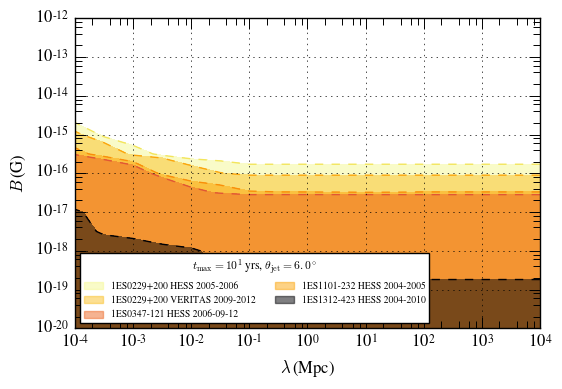

In [72]:
plt.close()
fig = plt.figure(0)
ax = fig.add_subplot(111)
for isource, name  in enumerate(results['SOURCE_FULL']):
    LL, BB = np.meshgrid(10.**results['lcoh'][isource][:,0],
                         10.**results['igmf'][isource][0,:], 
                        indexing = 'ij')
    
    dloglike = results['dloglike'][isource]
    if results['name'][isource] in no_lim: continue
    
    plt.contourf(LL,BB,2*dloglike, [-1e5,-6.18],
             colors = [cp( m * exclAreas[name] + b)],
             linestyles = ['-'],
             zorder = -(m * exclAreas[name] + b),
             alpha = 0.5
            )
            
    c = plt.contour(LL,BB,2*dloglike, [-1e5,-6.18],
             colors = [cp( m * exclAreas[name] + b - 0.05)],
             linestyles = ['--'],
             label = name
            )
    handles.append(mpatches.Patch(
                    color= cp( m * exclAreas[name] + b),
                    alpha = 0.5,
                    label = ' '.join(name.split('_'))))
    
title = '$t_\mathrm{{max}} = 10^{0:.0f}$ yrs, $\\theta_\mathrm{{jet}} = {1:.1f}^\circ$'.format(
        np.log10(config['tmax']), config['th_jet'])

plt.grid(True)

plt.legend(loc = 'lower left', handles = handles, fontsize = 'x-small',
          ncol = 2, title = title)
ax.get_legend().get_title().set_fontsize('small')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$B\,$(G)')
ax.set_xlabel('$\lambda\,$(Mpc)')


fname = 'dL_tmax{0[tmax]:.0e}_thj{0[th_jet]:.0f}'.format(config)
plt.savefig('./plots/' + fname + '.png', format = 'png', dpi = 200)
plt.savefig('./plots/' + fname + '.pdf', format = 'pdf')

#### make the plot without the IACT likelihood

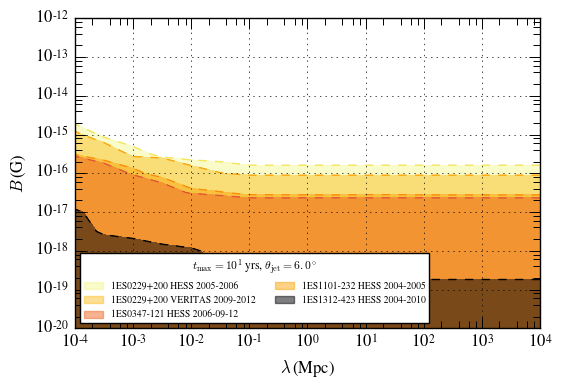

In [73]:
plt.close()

fig = plt.figure(1)
ax = fig.add_subplot(111)
handles = []
for isource, name  in enumerate(results['SOURCE_FULL']):
    LL, BB = np.meshgrid(10.**results['lcoh'][isource][:,0],
                         10.**results['igmf'][isource][0,:], 
                        indexing = 'ij')
    
    dloglike = np.sum(results['loglike_comp'][isource][...,1:], axis = -1)
    dloglike = -(dloglike - np.min(dloglike))
    
    if results['name'][isource] in no_lim: continue
    
    plt.contourf(LL,BB,2*dloglike, [-1e5,-6.18],
             colors = [cp( m * exclAreas[name] + b)],
             linestyles = ['-'],
             zorder = -(m * exclAreas[name] + b),
             alpha = 0.5
            )
            
    c = plt.contour(LL,BB,2*dloglike, [-1e5,-6.18],
             colors = [cp( m * exclAreas[name] + b - 0.05)],
             linestyles = ['--'],
             label = name
            )
    handles.append(mpatches.Patch(
                    color= cp( m * exclAreas[name] + b),
                    alpha = 0.5,
                    label = ' '.join(name.split('_'))))

title = '$t_\mathrm{{max}} = 10^{0:.0f}$ yrs, $\\theta_\mathrm{{jet}} = {1:.1f}^\circ$'.format(
        np.log10(config['tmax']), config['th_jet'])

plt.grid(True)

plt.legend(loc = 'lower left', handles = handles, fontsize = 'x-small',
          ncol = 2, title = title)
ax.get_legend().get_title().set_fontsize('small')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$B\,$(G)')
ax.set_xlabel('$\lambda\,$(Mpc)')

fname = 'dLFermi_tmax{0[tmax]:.0e}_thj{0[th_jet]:.0f}'.format(config)
plt.savefig('./plots/' + fname + '.png', format = 'png', dpi = 200)
plt.savefig('./plots/' + fname + '.pdf', format = 'pdf')

### Combine the likelihoods

In [74]:
combined_dL_spec = [x[0] for x in combined_dl_src.values()]

dloglike = []
for isource, name  in enumerate(results['SOURCE_FULL']):
    if not name in combined_dL_spec: continue
    dloglike.append(results['dloglike'][isource])
dloglike = np.array(dloglike).sum(axis = 0)

Plot the combined likelihood:

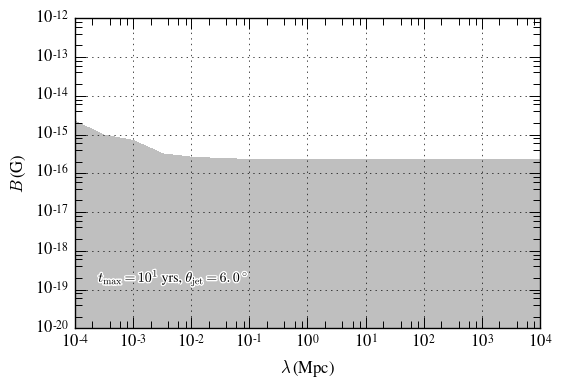

In [75]:
ax = plt.subplot(111)
plt.contourf(LL,BB,2*dloglike, [-1e5,-6.18],
             colors = ['0.5'],
             linestyles = ['-'],
             alpha = 0.5
            )

title = '$t_\mathrm{{max}} = 10^{0:.0f}$ yrs, $\\theta_\mathrm{{jet}} = {1:.1f}^\circ$'.format(
        np.log10(config['tmax']), config['th_jet'])

plt.annotate(title, xy = (0.05,0.15), xycoords = 'axes fraction', 
             path_effects=[withStroke(foreground="w", linewidth=2)])

plt.grid(True)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$B\,$(G)')
ax.set_xlabel('$\lambda\,$(Mpc)')

fname = 'Comb_dL_tmax{0[tmax]:.0e}_thj{0[th_jet]:.0f}'.format(config)
plt.savefig('./plots/' + fname + '.png', format = 'png', dpi = 200)
plt.savefig('./plots/' + fname + '.pdf', format = 'pdf')

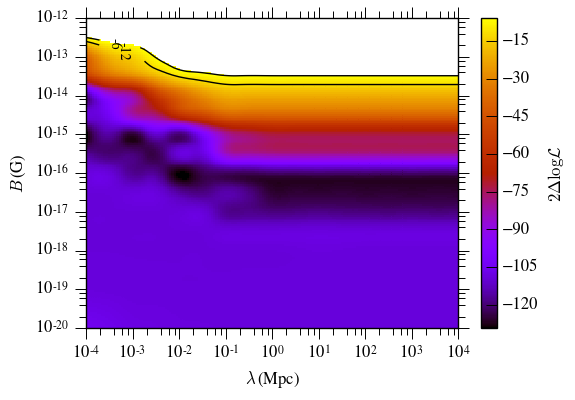

In [19]:
dloglike = results['dloglike'][isource]


#plt.pcolormesh(10**ll,10**bb,2*dloglike,
#               cmap=cmap, #edgecolors = 'skyblue', lw = 0.01,
              # vmax=0.0,vmin=int(np.min(dloglike))
#              )
#cb = plt.colorbar(label = '$2\Delta \log \mathcal{L}$')
#plt.gca().set_xlim(np.min(10.**ll),np.max(10.**ll))
#plt.gca().set_ylim(np.min(10.**bb),np.max(10.**bb))

cp = plt.cm.gnuplot
cp.set_over('1.')
BB, LL = np.meshgrid(10.**results['igmf'][isource][0,:], 10.**results['lcoh'][isource][:,0])
plot_map_countours(LL,BB,2*dloglike, [-11.83,-6.18],
                   colbarlabel = '$2\Delta \log \mathcal{L}$',
                  colmap = cp,
                  #vmin = -50, vmax = 0.,
                   vmin = np.min(2*dloglike), vmax = -6.
                   #set_under = '1.'
                  )

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_ylabel('$B\,$(G)')
plt.gca().set_xlabel('$\lambda\,$(Mpc)')

tics_out(plt.gca())


### Single $\Delta\log\mathcal{L}$

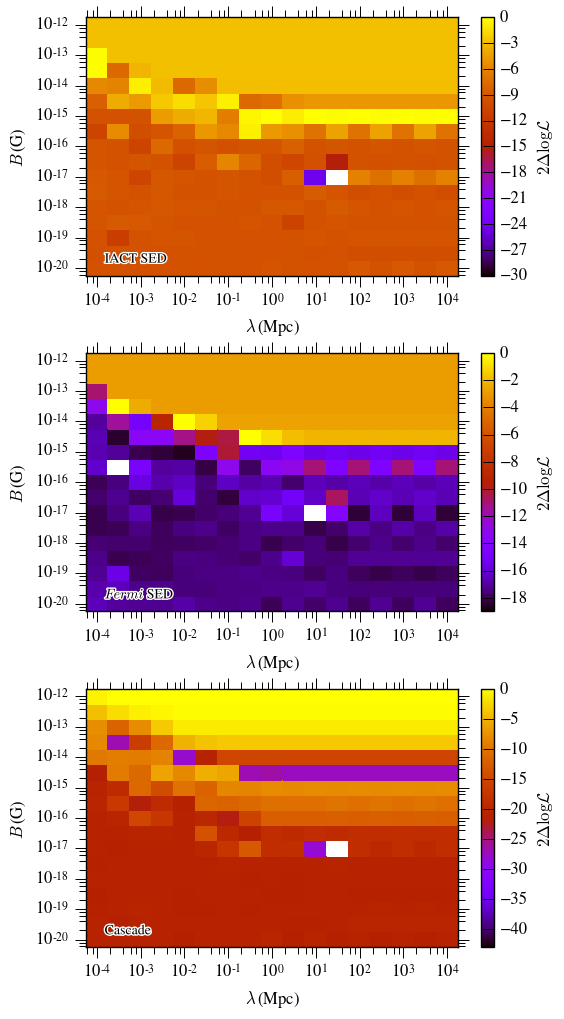

In [362]:
loglike = np.rollaxis(results['loglike_comp'][isource],2)

label = ['IACT SED', '$\mathit{Fermi}$ SED', 'Cascade']

plt.figure(figsize = (6,4*3))
for i,logl in enumerate(loglike):
    ax = plt.subplot(loglike.shape[0],1,i+1)
    dl = -2.*(logl - np.min(logl))
    #dl = -logl
    plt.pcolormesh(10**ll,10**bb,
                   dl,
                   cmap=cp,
        #            edgecolors = 'skyblue', lw = 0.01,
                   vmax=int(np.max(dl)),
                   vmin=int(np.min(dl)))
    
    
    cb = plt.colorbar(label = '$2\Delta \log \mathcal{L}$')
    ax.set_ylabel('$B\,$(G)')
    ax.set_xlabel('$\lambda\,$(Mpc)')
    #ax.grid(True, color = 'skyblue')
    ax.set_xscale('log')
    ax.set_yscale('log')
    tics_out(ax)
    
    ax.set_xlim(np.min(10.**ll),np.max(10.**ll))
    ax.set_ylim(np.min(10.**bb),np.max(10.**bb))
    
    ax.annotate(label[i], xy = (0.05,0.05), xycoords = 'axes fraction', **effect)
plt.subplots_adjust(hspace = 0.3)

### combine likelihoods from Fermi only

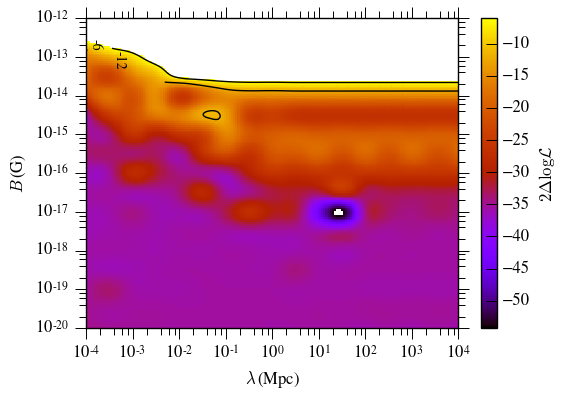

In [363]:
dloglike_fermi = np.sum(results['loglike_comp'][isource][...,1:], axis = -1)
#dloglike -= np.max(dloglike)

dloglike_fermi = -(dloglike_fermi - np.min(dloglike_fermi))

plot_map_countours(LL,BB,2*dloglike_fermi, [-11.83,-6.18],
                   colbarlabel = '$2\Delta \log \mathcal{L}$',
                  colmap = cp,
                  #vmin = -50, vmax = 0.,
                   vmin = np.min(2*dloglike_fermi), vmax = -6.
                   #set_under = '1.'
                  )

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_ylabel('$B\,$(G)')
plt.gca().set_xlabel('$\lambda\,$(Mpc)')
#plt.gca().grid(True, color = 'skyblue')
#plt.gca().set_xlim(np.min(10.**ll),np.max(10.**ll))
#plt.gca().set_ylim(np.min(10.**bb),np.max(10.**bb))

tics_out(plt.gca())
